In [66]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [67]:
# Import
df0 = pd.read_csv('Sample_Market_SKU_data.csv')
#NOTE: This is a horizontal, row-wise, time series dataset
df0.head()

,Market,Sales Product,21-Dec,22-Jan,22-Feb,22-Mar,22-Apr,22-May,22-Jun,22-Jul,...,24-Feb,24-Mar,24-Apr,24-May,24-Jun,24-Jul,24-Aug,24-Sep,24-Oct,24-Nov
0,AFRICA,AB12345,305,302,1503,1471,1583,2080,1490,672,...,787,1417,847,777,1128,1427,846,1475,1572,927
1,ASIA,AB12346,1892,1071,2065,841,1542,2142,691,103,...,615,1166,1538,1206,1129,290,426,762,1775,777
2,OCEANIA,AC12347,1728,1912,193,102,465,1279,1748,1817,...,1834,1392,1746,759,2258,2062,223,142,635,1295
3,EUROPE,AD12348,776,1499,660,1127,214,174,351,1184,...,561,316,1961,1005,1936,331,432,873,1753,870
4,NORTH AMERICA,AS12349,720,1101,1516,1395,967,44,638,521,...,975,1329,933,310,1533,1836,1644,2095,2268,1076


In [68]:
#Remove the non-numeric columns,
#Find the shape for tensor operations
df1=df0.iloc[:1,2:] #select the first time series AFRICA	AB12345	
df1.shape


(1, 36)

In [69]:
training_set0=np.array(df1)
training_set=training_set0.reshape(36,)
training_set.shape

(36,)

In [70]:
data=training_set
# Define lookback window
lookback_window =6
# Create input and output sequences
X = []
y = []
for i in range(lookback_window, len(data)):
    X.append(data[i - lookback_window:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)
# Split into training and testing sets
train_size = int(len(X) * 0.95)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [71]:
X_train.shape

(28, 6)

In [72]:
X_test.shape

(2, 6)

In [73]:
# Create a Temporal CNN model
model = Sequential()
model.add(Conv1D(36, kernel_size=3, activation='relu', input_shape=(lookback_window, 1))) #MAE decreases with the increase in Conv1D nodes(32 in this case)
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='relu'))  # Adjust output units based on your task
#Compile
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=3, verbose=False)

# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

1/1 [==============================] - 0s 65ms/step
Mean Squared Error: 377230.18992485106
Mean Absolute Error: 614.1334228515625


In [74]:
# Predict the next 21 points with feedback
n_future = 21
y_future = []
x_pred = X[-1:, :]  # last observed input sequence
y_pred = y[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:], y_pred.reshape(1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

print(x_pred)

1/1 [==============================] - 0s 24ms/step
[[744.90472412 740.50457764 710.49414062 668.49310303 636.40686035
  610.18951416]]


In [75]:
# Create a DataFrame for the predicted values
predictions_df2 = pd.DataFrame({'Predicted Values': y_future})
# Save the predictions to a CSV file and export it
predictions_df2.to_csv('predictions_TCNN_OUTPUT.csv', index=False)

In [76]:
#Create dataframes to visualise the forecast
data_df=pd.DataFrame(data)
y_future=pd.DataFrame(y_future)
#Add empty rows in y_future for historical data
df_zero=pd.DataFrame(np.zeros(len(data_df)))
#Concat empty rows with y_future for historical data
y_future2=pd.concat([df_zero,y_future],ignore_index=True,axis=0)
#Concat y_future2 with historical dat
final=pd.concat([data_df,y_future2], ignore_index=True,axis=1)

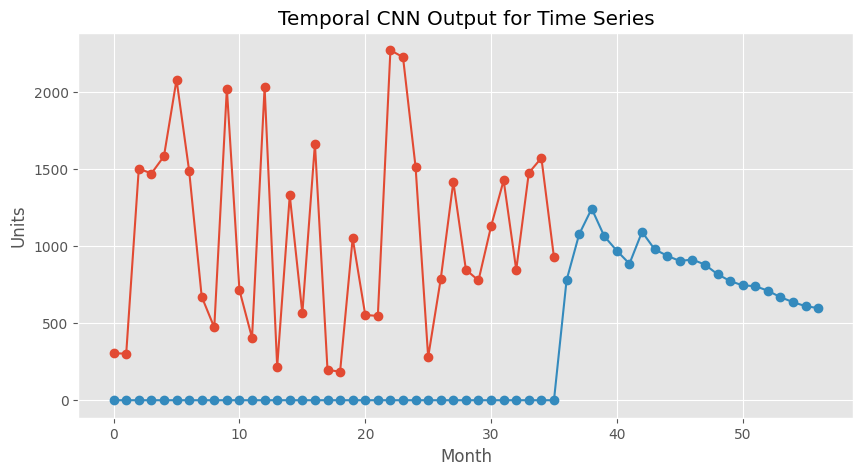

In [77]:
#Plot with the forecast with actuals
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(final, marker='o')
plt.title('Temporal CNN Output for Time Series')
plt.xlabel('Month')
plt.ylabel('Units')
plt.show()